# The objective of the assignment is to compute the reliability of a wind turbine blade against fatigue failure in its root section. It requires defining a limit state function and estimating the probability of failure based on different environmental and material variables

In [215]:
# Importing libraries once

import numpy as np
import os
import pandas as pd
import scipy.stats as stats
import scipy
import matplotlib.pyplot as plt
import sklearn
import sklearn.neural_network
import openturns as ot

## Two datasets are provided: 
 - Hovsore = 10-minute average wind speeds, directions, turbulence at Høvsøre over 10 
years, including timestamp
 - DEL = data of simulated 10-minute realizations of damage 
equivalent loads (DEL) for the DTU 10MW reference wind turbine as function of various external 
conditions, including wind speed, turbulence, wind shear.

In [216]:
# Directory containing the files (current working directory)
current_dir = os.getcwd()  # gets the path of the folder where the code is run
Hovsore_data_filepath = os.path.join(current_dir, 'HovsoreData_Sonic_100m_2004-2013.csv')
DEL_data_filepath = os.path.join(current_dir, 'ML_ExampleDataSet.xlsx')
# Load Hovsore wind data CSV
Hovsore_data = pd.read_csv(Hovsore_data_filepath)

# Load DEL data from Excel
DEL_data = pd.read_excel(DEL_data_filepath)  # Read all sheets for now

# Preview the datasets
Hovsore_data.head()
#DEL_data.head()


,Timestamp,Wsp,TI,"TI,detrend",MeanDir,MeanTrigDir,StdDir,MinDir,MaxDir
0,200410010000,9.9196,0.0181,0.0145,346.7130,346.7130,0.8440,343.893,349.044
1,200410010020,9.5073,0.0145,0.0116,346.9852,346.9852,0.6518,344.751,348.949
2,200410010030,9.5274,0.0210,0.0195,346.9152,346.9151,0.7949,343.754,350.588
3,200410010040,9.9498,0.0253,0.0195,346.3204,346.3204,0.7549,343.971,349.953
4,200410010050,10.2376,0.0151,0.0134,345.4185,345.4185,0.6362,343.074,348.960


# Data preparation

## Filtering: nTreating the data to remove any outlier(i.e. removing the wind speeds any higher than 45 m/s) 

In [217]:
# Remove rows where Wsp is greater than 50
Hovsore_filtered_data = Hovsore_data[Hovsore_data['Wsp'] <= 45].reset_index(drop=True)
# remove rows where TI is 0
Hovsore_filtered_data = Hovsore_filtered_data[Hovsore_filtered_data['TI'] > 0].reset_index(drop=True)

# Add a new column 'Total_Cost' that is the product of 'Quantity' and 'Price_per_Item'
Hovsore_filtered_data['SigmaU'] = Hovsore_filtered_data['Wsp'] * Hovsore_filtered_data['TI']
Hovsore_data.head()

,Timestamp,Wsp,TI,"TI,detrend",MeanDir,MeanTrigDir,StdDir,MinDir,MaxDir
0,200410010000,9.9196,0.0181,0.0145,346.7130,346.7130,0.8440,343.893,349.044
1,200410010020,9.5073,0.0145,0.0116,346.9852,346.9852,0.6518,344.751,348.949
2,200410010030,9.5274,0.0210,0.0195,346.9152,346.9151,0.7949,343.754,350.588
3,200410010040,9.9498,0.0253,0.0195,346.3204,346.3204,0.7549,343.971,349.953
4,200410010050,10.2376,0.0151,0.0134,345.4185,345.4185,0.6362,343.074,348.960


## Visualization

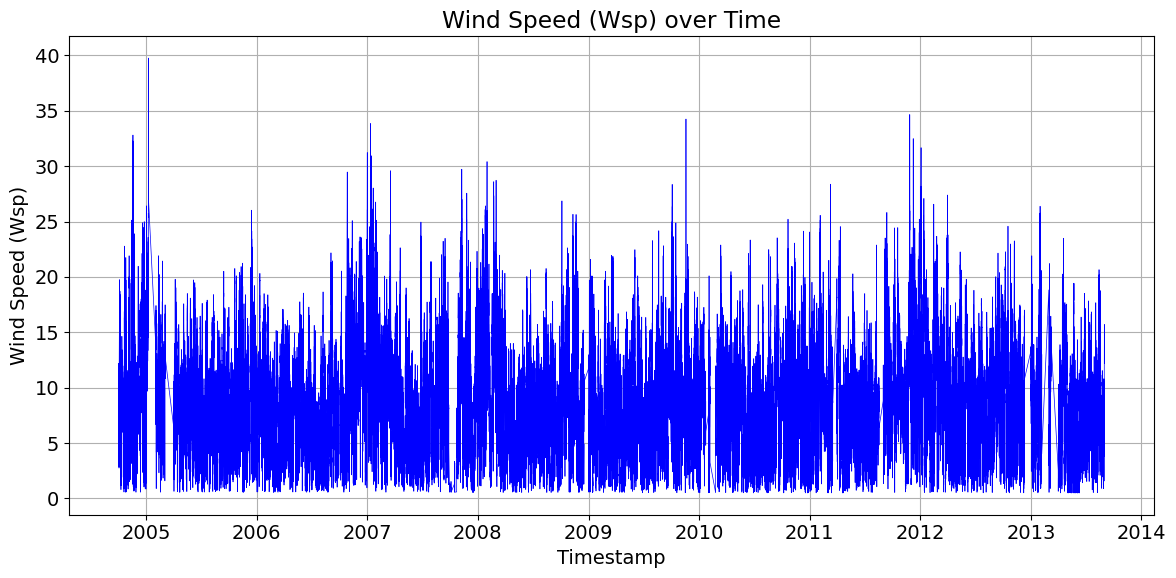

In [218]:
# Convert the Timestamp column to datetime format
Hovsore_filtered_data['Timestamp'] = pd.to_datetime(Hovsore_filtered_data['Timestamp'], format='%Y%m%d%H%M')

# Plotting Wsp against Timestamp
plt.figure(figsize=(12, 6))
plt.plot(Hovsore_filtered_data['Timestamp'], Hovsore_filtered_data['Wsp'], color='blue', linewidth=0.5)
plt.title('Wind Speed (Wsp) over Time')
plt.xlabel('Timestamp')
plt.ylabel('Wind Speed (Wsp)')
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

## Fit a marginal Weibull distribution to the wind speed

In [219]:
# WIND SPEED DISTRIBUTION FIT
# Weibull distribution fit using the max-likelihood method
Wsp0 = np.asarray(Hovsore_filtered_data['Wsp'])

WeibLikelihoodFunc = lambda theta: -np.sum( stats.weibull_min.logpdf(Wsp0,c = theta[1],scale=theta[0]) )
Weib0 = scipy.optimize.minimize(WeibLikelihoodFunc,[2,1])

WeibullA = Weib0.x[0]
Weibullk = Weib0.x[1]

print('Distribution parameters using the max-likelihood method: A = ' + str(Weib0.x[0]) + ', k = ' + str(Weib0.x[1]))

Distribution parameters using the max-likelihood method: A = 9.98256948470993, k = 2.0325587954422955


## Fit a conditional LogNormal distribution to the turbulence, considering a linear or quadratic dependence of the mean turbulence to the wind speed

In [220]:
# Helper function - Normal distribution
def NormalDist(task,x,mu=0,sigma=1):
    import numpy as np
    if task == 0: # PDF
        y = (1.0/(sigma*np.sqrt(2.0*np.pi)))*np.exp(-((x - mu)**2)/(2.0*(sigma**2)))
    elif task == 1: # Cumulative
        from scipy.special import erf
        y = 0.5*(1.0 + erf((x - mu)/(sigma*np.sqrt(2))))
    elif task == 2: # Inverse
        from scipy.special import erfinv
        y = mu + sigma*np.sqrt(2)*erfinv(2*x - 1)        
    return y

# Helper function - lognormal distribution
def LogNormDist(task,x,mu,sigma):
    import numpy as np
    tol = 1e-16
    mu = np.asarray(mu)
    mu[mu<tol] = tol
    Eps   = np.sqrt(np.log( 1.0+(sigma/mu)**2 ) )
    Ksi   = np.log(mu)-0.5*Eps**2
    if task == 0: # PDF
        x[x<=0] = 1e-8
        u =(np.log(x)-Ksi)/Eps
        y = np.exp(-u*u/2.0)/(Eps*x*np.sqrt(2.0*np.pi))
    elif task == 1: # Cummulative
        x[x<=0] = 1e-8
        u =(np.log(x)-Ksi)/Eps
        y= NormalDist(1, u)
    elif task == 2: # Inverse
        y= np.exp(Ksi+Eps*NormalDist(2, x))
    
    return y

In [221]:
# CONDITION DISTRIBUTION OF TURBULENCE - BASED ON DATA BINNING
WspBinEdges = np.arange(3.5,43.5,1)
WspBinCenters = WspBinEdges[:-1] + 0.5

MuSigmaBinned = np.zeros(len(WspBinCenters))
SigmaSigmaBinned = np.zeros(len(WspBinCenters))

nData = len( Hovsore_filtered_data['Wsp'])
    
# Per wind speed
for iWsp in range(len(WspBinCenters)):
    WspBinSelection = ( Hovsore_filtered_data['Wsp'] > WspBinEdges[iWsp]) & ( Hovsore_filtered_data['Wsp'] <= WspBinEdges[iWsp + 1])
    MuSigmaBinned[iWsp] = np.mean(Hovsore_filtered_data.loc[WspBinSelection,'SigmaU'])
    SigmaSigmaBinned[iWsp] = np.std(Hovsore_filtered_data.loc[WspBinSelection,'SigmaU'])
    
Mudatax = WspBinCenters[~np.isnan(MuSigmaBinned)]
Mudatay = MuSigmaBinned[~np.isnan(MuSigmaBinned)]
SigmaSigmaBinned = SigmaSigmaBinned[~np.isnan(MuSigmaBinned)]

# Use polyfit (for example np.polyfit). Which order works well - 0, 1, or 2?
# You can choose the order of the polynomial (0 for constant, 1 for linear, 2 for quadratic)
pMu = np.polyfit(Mudatax, Mudatay, deg=2)


SigmaSigmaRef = np.mean(SigmaSigmaBinned)
        
MuSigmaFunc = lambda u: np.polyval(pMu, u)
SigmaSigmaFunc = lambda u:  SigmaSigmaRef #np.ones(shape = np.shape(u)) * SigmaSigmaRef


In [222]:
InputData = pd.read_excel('ML_ExampleDataSet.xlsx','InputVariables')
#InputData.index = InputData['Sample_No'] # Make the "Sample_No" column as index of the data
InputData = InputData.set_index('Sample_No',drop = False)
InputData.drop(columns = ['MannL', 'MannGamma', 'VeerDeltaPhi'], inplace = True) # Remove unnecessary columns

TargetData = pd.read_excel('ML_ExampleDataSet.xlsx','LoadResults')
TargetData.set_index('PointNo', drop = False, inplace = True) # Make the "PointNo" column as index of the data

AllInputData = InputData.where(InputData['Sample_No']==TargetData['PointNo'])
AllTargetData = TargetData.where(TargetData['PointNo']==InputData['Sample_No'])
AllInputData.drop(columns = 'Sample_No', inplace = True)
AllTargetData.drop(columns = 'PointNo', inplace = True)
nsamples = AllInputData['U'].count() # Find the total number of data points in the data frame
FeatureNames = AllInputData.columns.values
DependentVariableNames = AllTargetData.columns.values
print('Feature names: ', FeatureNames)
print('Dependent variable names: ', DependentVariableNames)
print(AllInputData.iloc[:,0].values)

### chuse Target to model
futTargetName = 'Blade_root_flapwise_M_x'#'Tower_base_fore_aft_M_x'#'Blade_root_flapwise_M_x'

Feature names:  ['U' 'SigmaU' 'Alpha']
Dependent variable names:  ['Tower_top_fore_aft_M_x' 'Tower_top_side2side_M_y'
 'Tower_base_fore_aft_M_x' 'Tower_base_side2side_M_y' 'Yaw_moment_M_z'
 'Main_shaft_torsion_M_z' 'Blade_root_flapwise_M_x'
 'Blade_root_edgewise_M_y']
[ 4.         10.1507576   6.81346652 ... 13.32617204  9.2987816
 19.89821019]


In [223]:
Urand = stats.weibull_min.rvs(c= Weibullk, scale = WeibullA, size = 10000)
MuSigmaUrand = MuSigmaFunc(Urand)
Sigma_Urand = SigmaSigmaFunc(Urand)
SigmaUrand = LogNormDist(2, np.random.rand(10000), MuSigmaUrand, Sigma_Urand)

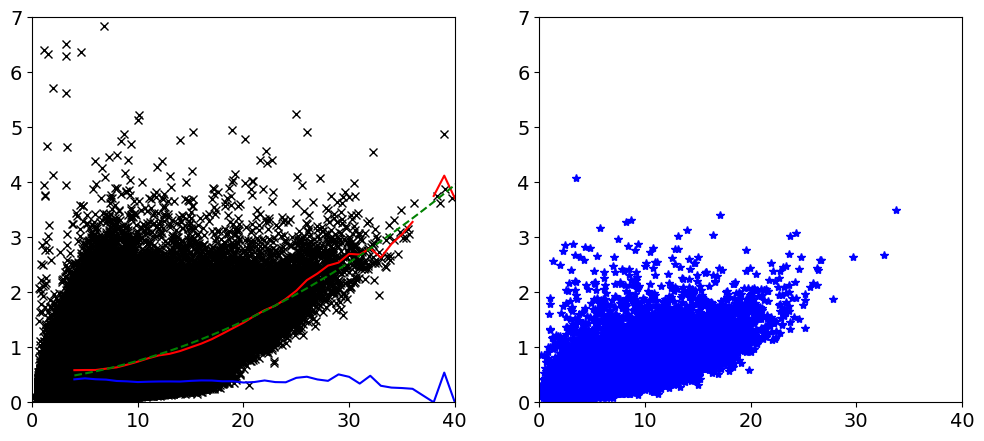

In [224]:
# PLOT TURBULENCE INCLUDING DISTRIBUTION PARAMETERS

fig,ax = plt.subplots(1,2, figsize = (12,5))
ax[0].plot(Hovsore_filtered_data['Wsp'],Hovsore_filtered_data['SigmaU'],'xk')
ax[0].plot(WspBinCenters,MuSigmaBinned,'-r')
ax[0].plot(WspBinCenters[~np.isnan(MuSigmaBinned)],SigmaSigmaBinned,'-b')
ax[0].plot(WspBinCenters,MuSigmaFunc(WspBinCenters),'--g')
ax[0].set_xlim([0,40])
ax[0].set_ylim([0,7])
ax[1].plot(Urand,SigmaUrand,'*b')
ax[1].set_xlim([0,40])
ax[1].set_ylim([0,7])
plt.show()

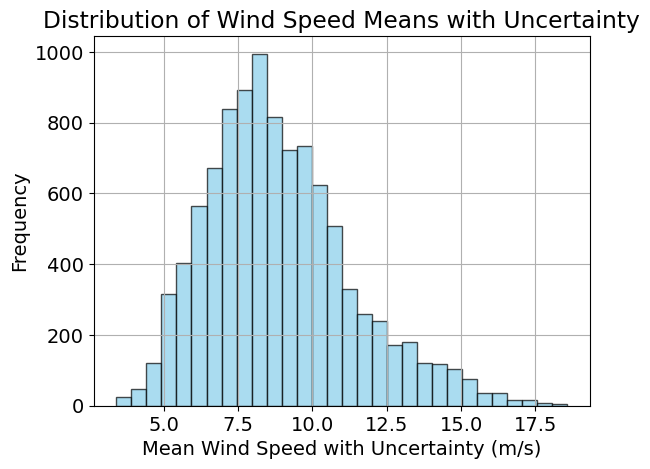

{'Mean': 8.8831359829352,
 'Standard Deviation': 2.4473653095078527,
 'Minimum': 3.4040890520000002,
 'Maximum': 18.567645272000004}

In [225]:
# Set parameters for bootstrapping
bootstrap_iterations = 10000  # Number of bootstrap samples
sample_length = 1000         # Number of consecutive points in each sample (adjustable for continuous segments)

# List to store the means of each bootstrap sample
bootstrap_means = []

# Perform bootstrapping
for _ in range(bootstrap_iterations):
    # Choose a random starting index
    start_index = np.random.randint(0, len(Hovsore_filtered_data) - sample_length)
    # Take a continuous segment of the specified length
    sample = Hovsore_filtered_data['Wsp'][start_index:start_index + sample_length]
    # Calculate and store the mean of the sample
    bootstrap_means.append(sample.mean())

# Convert to numpy array for calculations
bootstrap_means = np.array(bootstrap_means)

# Apply 1% uncertainty for wind speed measurement
adjusted_bootstrap_means = bootstrap_means * 1.01  # Adding 1% uncertainty

# Plotting the distribution of bootstrap means
plt.hist(adjusted_bootstrap_means, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Mean Wind Speed with Uncertainty (m/s)')
plt.ylabel('Frequency')
plt.title('Distribution of Wind Speed Means with Uncertainty')
plt.grid(True)
plt.show()

# Calculate basic statistics of the adjusted bootstrap means
bootstrap_mean_stats = {
    'Mean': np.mean(adjusted_bootstrap_means),
    'Standard Deviation': np.std(adjusted_bootstrap_means),
    'Minimum': np.min(adjusted_bootstrap_means),
    'Maximum': np.max(adjusted_bootstrap_means)
}

bootstrap_mean_stats


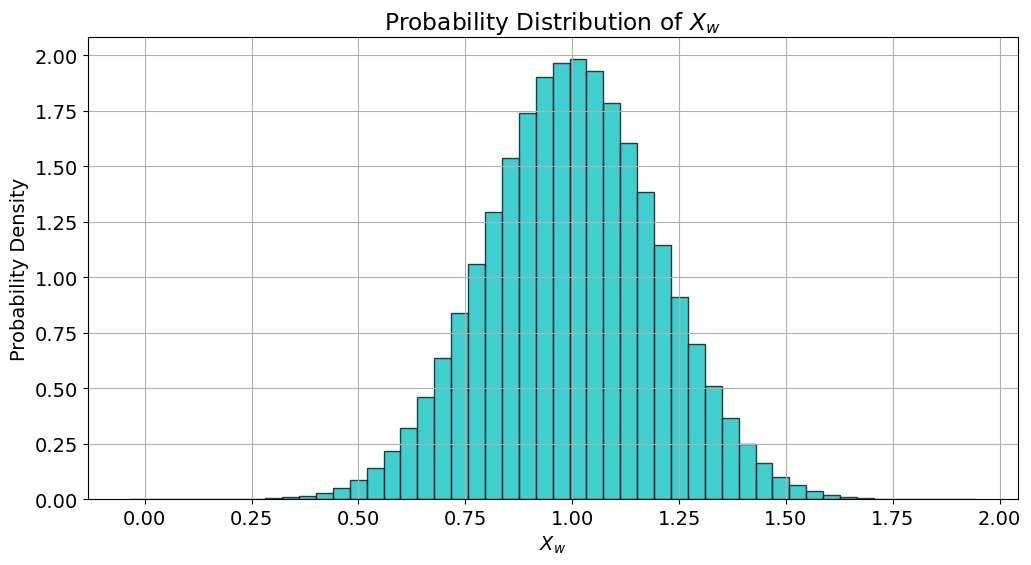

In [226]:
# Convert the Timestamp to datetime format and set it as index
Hovsore_filtered_data['Timestamp'] = pd.to_datetime(Hovsore_filtered_data['Timestamp'], format='%Y%m%d%H%M')
Hovsore_filtered_data.set_index('Timestamp', inplace=True)

# Define a function to perform bootstrap sampling using continuous segments
def bootstrap_continuous_segments(data, sample_size, n_bootstrap):
    """
    Perform bootstrap sampling with continuous segments.

    Parameters:
    data (pd.Series): Wind speed data to be sampled.
    sample_size (int): The number of points in each bootstrap sample.
    n_bootstrap (int): The number of bootstrap samples.

    Returns:
    list of np.ndarray: List of bootstrap samples.
    """
    total_length = len(data)
    bootstrap_samples = []
    
    for _ in range(n_bootstrap):
        # Randomly select a starting point ensuring that the sample will not exceed the data length
        start_index = np.random.randint(0, total_length - sample_size)
        # Select a continuous segment of data
        sample = data.iloc[start_index:start_index + sample_size].values
        bootstrap_samples.append(sample)
    
    return bootstrap_samples

# Parameters for bootstrap sampling
sample_size = 10000  # Number of points in each bootstrap sample
n_bootstrap = 100  # Number of bootstrap samples

# Get bootstrap samples using the wind speed column
wind_speed_samples = bootstrap_continuous_segments(Hovsore_filtered_data['Wsp'], sample_size, n_bootstrap)
'''
# Visualize the first 5 bootstrap samples to verify the continuity
plt.figure(figsize=(14, 6))
for i, sample in enumerate(wind_speed_samples[:5]):
    plt.plot(sample, label=f'Sample {i+1}')
plt.title('Continuous Segments of Bootstrap Samples')
plt.xlabel('Sample Index')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid()
plt.show()
'''


# Define parameters for X_w
mean_Xw = 1  # Mean of X_w
cov_Xw = 0.2  # Coefficient of Variation of X_w
std_Xw = mean_Xw * cov_Xw  # Standard deviation of X_w

# Introduce 1% measurement and fitting uncertainty
measurement_uncertainty_factor = 0.01
fitting_uncertainty_factor = 0.01

# Apply uncertainties to each bootstrap sample and calculate corresponding X_w values
x_w_values = []
for sample in wind_speed_samples:
    # Apply measurement uncertainty
    sample_with_uncertainty = sample * (1 + np.random.normal(0, measurement_uncertainty_factor, len(sample)))
    
    # Apply fitting uncertainty
    sample_with_uncertainty = sample_with_uncertainty * (1 + np.random.normal(0, fitting_uncertainty_factor, len(sample)))
    
    # Calculate X_w using the normal distribution with mean 1 and CoV
    x_w_sample = np.random.normal(mean_Xw, std_Xw, len(sample_with_uncertainty))
    
    # Store the X_w values
    x_w_values.extend(x_w_sample)

# Visualize the probability distribution of X_w
plt.figure(figsize=(12, 6))
plt.hist(x_w_values, bins=50, density=True, alpha=0.75, color='c', edgecolor='black')
plt.title('Probability Distribution of $X_w$')
plt.xlabel('$X_w$')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()


###  ML regresion model for M_X(U, SigmaU, alpha)

In [227]:
# SKLEARN Neural Network MLP regressor model
Mx_model = sklearn.neural_network.MLPRegressor()

In [228]:
# Normalise data for regression
Xscaler = sklearn.preprocessing.StandardScaler()
Yscaler = sklearn.preprocessing.StandardScaler()
Xscaler = Xscaler.fit(AllInputData)
Yscaler = Yscaler.fit(AllTargetData[futTargetName].values.reshape(-1, 1))

TrainTestRatio = 0.8
N = len(AllInputData)
Xtrain = Xscaler.transform(AllInputData.values[:int(N*TrainTestRatio),:])
Xtest = Xscaler.transform(AllInputData.values[int(N*TrainTestRatio):,:])

Ytrain = Yscaler.transform(AllTargetData[futTargetName].values[:int(N*TrainTestRatio)].reshape(-1,1))
Ytest = Yscaler.transform(AllTargetData[futTargetName].values[int(N*TrainTestRatio):].reshape(-1,1))

#Xtrain = Xscaler.transform(AllInputData.values)
#Ytrain = Yscaler.transform(AllTargetData[futTargetName].values.reshape(-1,1))

# END CODE HERE

#Xtest = Xtrain
#Ytest = Ytrain

c:\Users\aletc\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\aletc\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [229]:
Mx_model.set_params(learning_rate_init = 0.01, activation = 'relu',tol = 1e-6,n_iter_no_change = 10, hidden_layer_sizes = (100,100), validation_fraction = 0.1)
# BEGIN CODE HERE
Mx_model.fit(Xtrain,Ytrain)
# END CODE HERE

c:\Users\aletc\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(hidden_layer_sizes=(100, 100), learning_rate_init=0.01, tol=1e-06)

In [230]:
# COMPUTE MODEL PREDICTIONS FOR ALL TEST DATA:
# Yout = Yscaler.inverse_transform(Mx_model.predict(Xtrain).reshape(-1, 1))
# Yout_test = Yscaler.inverse_transform(Mx_model.predict(Xtest).reshape(-1, 1))

# Function for computing model predictions
Mx_func = lambda X: Yscaler.inverse_transform(Mx_model.predict(Xscaler.transform(X)).reshape(-1, 1))


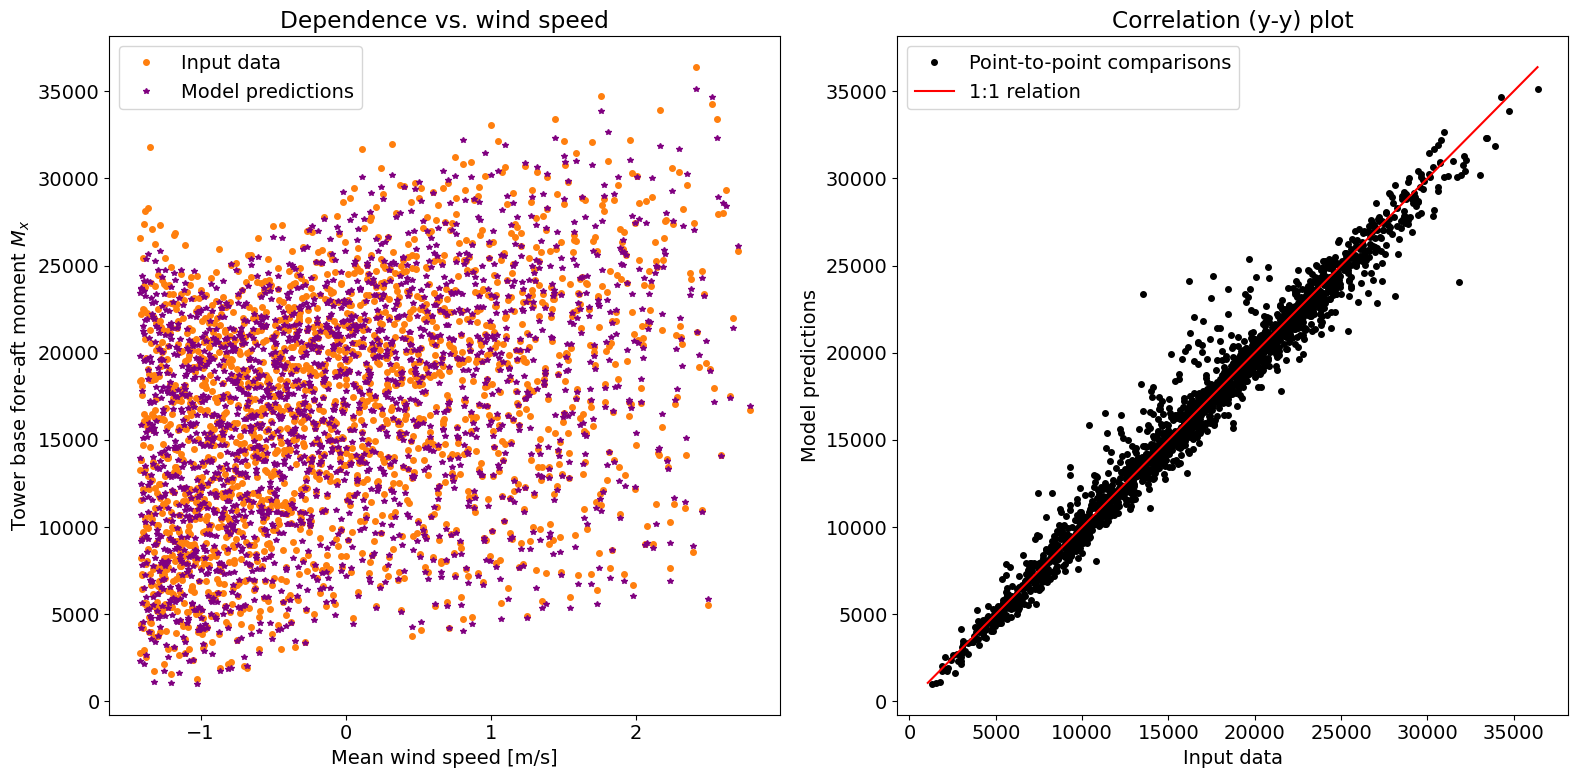

In [231]:
# plot against training data
Yout = Yscaler.inverse_transform(Mx_model.predict(Xtrain).reshape(-1, 1))
Yout_test = Yscaler.inverse_transform(Mx_model.predict(Xtest).reshape(-1, 1))


plt.rc('font', size=14) 
fig3,axs3 = plt.subplots(1,2,figsize = (16,8))
plt.setp(axs3[0], title = 'Dependence vs. wind speed', xlabel = 'Mean wind speed [m/s]',ylabel = 'Tower base fore-aft moment $M_x$')
plt.setp(axs3[1], title = 'Correlation (y-y) plot', xlabel = 'Input data',ylabel = 'Model predictions')
axs3[0].plot(Xtest[:,0],Yscaler.inverse_transform(Ytest),'o',markersize = 4,color = 'C1')
axs3[0].plot(Xtest[:,0],Yout_test,'*',markersize = 4,color = 'purple')
axs3[0].legend(['Input data','Model predictions'])
axs3[1].plot(Yscaler.inverse_transform(Ytest),Yout_test,'ok',markersize = 4)
axs3[1].plot(np.array([np.min(AllTargetData[futTargetName]), np.max(AllTargetData[futTargetName])]),\
             np.array([np.min(AllTargetData[futTargetName]), np.max(AllTargetData[futTargetName])]),'-r')
axs3[1].legend(['Point-to-point comparisons','1:1 relation'])
plt.tight_layout()             
plt.show()

# calculate Mx based on joint distribution and given apha distribution

In [232]:
# Function to generate random wind shear exponent alpha for an array of wind speeds
def generate_wind_shear_alpha(u):
    """
    Generates wind shear exponent (alpha) from a normal distribution for each wind speed in u.

    Parameters:
    u (array-like): Array of wind speeds.

    Returns:
    alpha (array): Randomly generated values of the wind shear exponent corresponding to wind speeds.
    """
    mean_alpha = 0.1  # Mean of the normal distribution
    
    # Calculate the standard deviation for each wind speed in the array (std = min(1, 1/u))
    std_alpha = np.minimum(1, 1 / u)
    
    # Generate normally distributed random variables for alpha with corresponding std for each wind speed
    alpha = np.random.normal(mean_alpha, std_alpha)
    
    return alpha

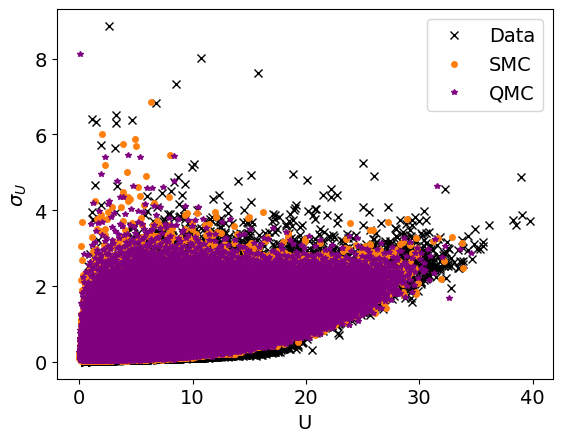

In [233]:
# GENERATE RANDOM VARIATES WITH OTHER SAMPLING TECHNIQUES

N_samples = 190000
ot.RandomGenerator.SetSeed(0)
dim = 2


uniform_distribution = ot.ComposedDistribution([ot.Uniform(0., 1.)] * dim)

# Crude Monte-Carlo
#SMC = np.random.rand(N_samples,dim)
SMC = uniform_distribution.getSample(N_samples)

U_SMC= stats.weibull_min.ppf(SMC[:,0], c=Weibullk, loc=0, scale = WeibullA) #stats.weibull_min.rvs(c= Weibullk, scale = WeibullA, size = 10000)
MuSigmaU_SMC = MuSigmaFunc(U_SMC)
SigmaSigma_SMC = SigmaSigmaFunc(U_SMC)
SigmaU_SMC = LogNormDist(2, SMC[:,1], MuSigmaU_SMC, SigmaSigma_SMC)
# wind shear alpha
alpha_SMC = generate_wind_shear_alpha(U_SMC)

# Quasi- Monte Carlo (QMC)
QMCexperiment = ot.LowDiscrepancyExperiment(ot.SobolSequence(), uniform_distribution, N_samples, False)
SQMC = QMCexperiment.generate()
SQMC = np.asarray(SQMC)#.T

U_QMC = stats.weibull_min.ppf(SQMC[:,0], c=Weibullk, loc=0, scale = WeibullA)
MuSigmaU_QMC = MuSigmaFunc(U_QMC)
SigmaSigma_QMC = SigmaSigmaFunc(U_QMC)
SigmaU_QMC = LogNormDist(2, SQMC[:,1], MuSigmaU_QMC, SigmaSigma_QMC)
# wind shear alpha
alpha_QMC = generate_wind_shear_alpha(U_QMC)

#plot of sigmaU vs U for SMC and QMC
plt.figure()
plt.plot(Hovsore_filtered_data['Wsp'],Hovsore_filtered_data['SigmaU'],'xk', label = 'Data')
plt.plot(U_SMC,SigmaU_SMC,'o',markersize = 4,color = 'C1', label = 'SMC')
plt.plot(U_QMC,SigmaU_QMC,'*',markersize = 4,color = 'purple', label = 'QMC')
plt.legend()
plt.xlabel('U')
plt.ylabel('$\sigma_U$')
plt.show()

In [234]:
# [U_SMC,SigmaU_SMC,alpha_SMC].ravel()
np.array([U_SMC.ravel(),SigmaU_SMC.ravel(),alpha_SMC.ravel()]).T
# [U_QMC,SigmaU_QMC,alpha_QMC]
# np.array([U_QMC,SigmaU_QMC,alpha_QMC]).T


array([[ 9.95265592e+00,  3.96189960e-01, -1.01236065e-01],
       [ 1.45275934e+01,  7.67993910e-01,  1.24509164e-01],
       [ 3.86501724e+00,  4.59126840e-01, -1.26758009e-01],
       ...,
       [ 1.99637673e+00,  3.09117814e-01,  1.31146545e+00],
       [ 1.78467149e+01,  1.08476304e+00, -2.31648875e-02],
       [ 1.03375394e+01,  5.86519340e-01, -1.76545701e-03]])

In [235]:
# get Mx predictions

# Crude Monte-Carlo
Mx_SMC = Mx_func(np.array([U_SMC.ravel(),SigmaU_SMC.ravel(),alpha_SMC.ravel()]).T)#np.array([U_SMC,SigmaU_SMC,alpha_SMC]).T
# Quasi- Monte Carlo (QMC)
Mx_QMC = Mx_func(np.array([U_QMC,SigmaU_QMC,alpha_QMC]).T)


c:\Users\aletc\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\aletc\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


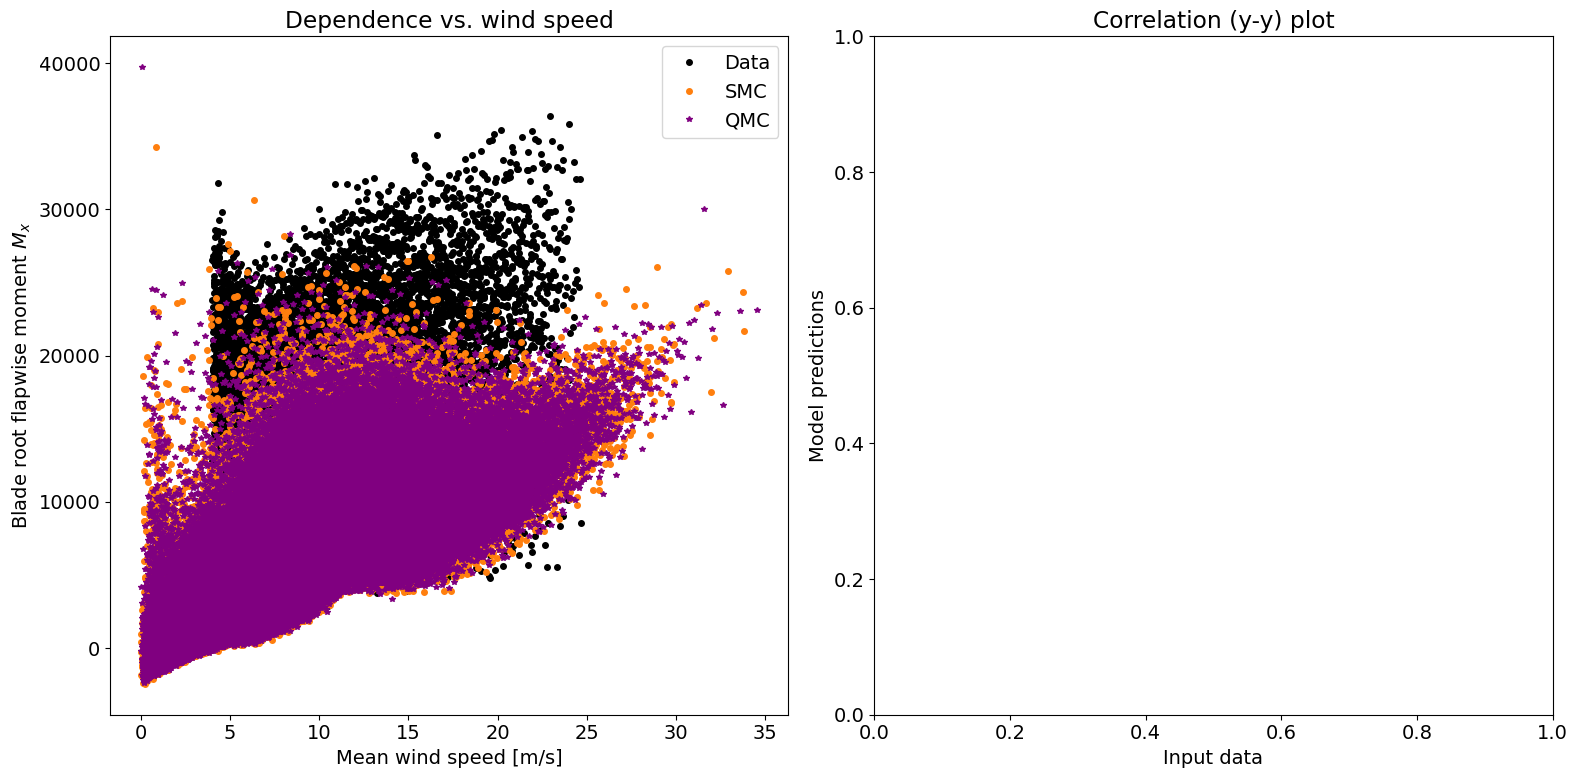

In [236]:
# plot
plt.rc('font', size=14) 
fig3,axs3 = plt.subplots(1,2,figsize = (16,8))
plt.setp(axs3[0], title = 'Dependence vs. wind speed', xlabel = 'Mean wind speed [m/s]',ylabel = 'Blade root flapwise moment $M_x$')
plt.setp(axs3[1], title = 'Correlation (y-y) plot', xlabel = 'Input data',ylabel = 'Model predictions')
axs3[0].plot(AllInputData['U'],AllTargetData[futTargetName],'o',markersize = 4,color = 'k')
axs3[0].plot(U_SMC,Mx_SMC,'o',markersize = 4,color = 'C1')
axs3[0].plot(U_QMC,Mx_QMC,'*',markersize = 4,color = 'purple')
axs3[0].legend(['Data','SMC','QMC'])
# axs3[1].plot(Yscaler.inverse_transform(Ytest),Yout_test,'ok',markersize = 4)
# axs3[1].plot(np.array([np.min(AllTargetData[futTargetName]), np.max(AllTargetData['Blade_root_flapwise_M_x'])]),\
#              np.array([np.min(AllTargetData['Blade_root_flapwise_M_x']), np.max(AllTargetData['Blade_root_flapwise_M_x'])]),'-r')
# axs3[1].legend(['Point-to-point comparisons','1:1 relation'])
plt.tight_layout()             
plt.show()

# lifetime damage and equivalent loads


C:\Users\aletc\AppData\Local\Temp\ipykernel_29052\423613677.py:13: RuntimeWarning: divide by zero encountered in divide
  LDEL_QMC_noUncertanty = (1/(np.arange(N_samples))*np.cumsum((Mx_func(np.array([U_QMC,SigmaU_QMC,alpha_QMC]).T).ravel())**m))**(1/m)
c:\Users\aletc\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\aletc\AppData\Local\Temp\ipykernel_29052\423613677.py:15: RuntimeWarning: divide by zero encountered in divide
  LDEL_QMC = (1/(np.arange(N_samples))*np.cumsum((Xin[:,1].T*Mx_func(np.array([(Xin[:,2].T*U_QMC),SigmaU_QMC,alpha_QMC]).T).ravel())**m))**(1/m)
c:\Users\aletc\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


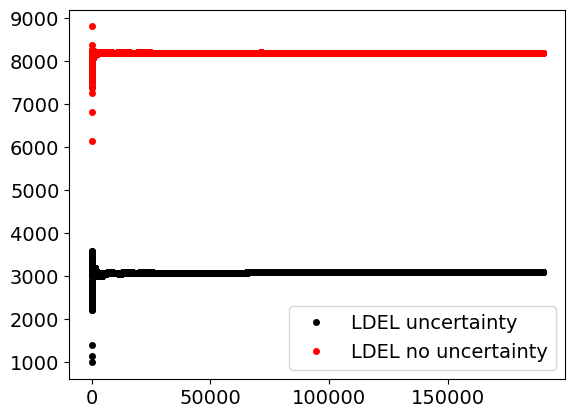

In [237]:
# sN curve paramiters
m = 3 #Fatigue S-N curve slope
k = 4*10**12 #Fatigue strength normalization factor

#uncertanty inputs
delta = LogNormDist(2, np.random.rand(N_samples), 1, 0.3)
Xm = LogNormDist(2, np.random.rand(N_samples), 1, 0.2)
Xw = np.ones(N_samples)*0.1# FIX!!!!!!!!!!!!!!!

Xin = np.array([delta.ravel(), Xm.ravel(),Xw.ravel()]).T

#ifetime equivilent damage loads
LDEL_QMC_noUncertanty = (1/(np.arange(N_samples))*np.cumsum((Mx_func(np.array([U_QMC,SigmaU_QMC,alpha_QMC]).T).ravel())**m))**(1/m)

LDEL_QMC = (1/(np.arange(N_samples))*np.cumsum((Xin[:,1].T*Mx_func(np.array([(Xin[:,2].T*U_QMC),SigmaU_QMC,alpha_QMC]).T).ravel())**m))**(1/m)

# plot
plt.plot(LDEL_QMC,'o',markersize = 4,color = 'k', label = 'LDEL uncertainty')
plt.plot(LDEL_QMC_noUncertanty,'o',markersize = 4,color = 'r', label = 'LDEL no uncertainty')
plt.legend()


C:\Users\aletc\AppData\Local\Temp\ipykernel_29052\984506948.py:2: RuntimeWarning: divide by zero encountered in divide
  Ldamage_QMC = 1/(np.arange(N_samples)*k)*np.cumsum((Xin[:,1].T*Mx_func(np.array([(Xin[:,2].T*U_QMC),SigmaU_QMC,alpha_QMC]).T).ravel())**m)
c:\Users\aletc\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\aletc\AppData\Local\Temp\ipykernel_29052\984506948.py:5: RuntimeWarning: divide by zero encountered in divide
  Ldamage_QMC_noUncertanty = 1/(np.arange(N_samples)*k)*np.cumsum((Mx_func(np.array([U_QMC,SigmaU_QMC,alpha_QMC]).T).ravel())**m)
c:\Users\aletc\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


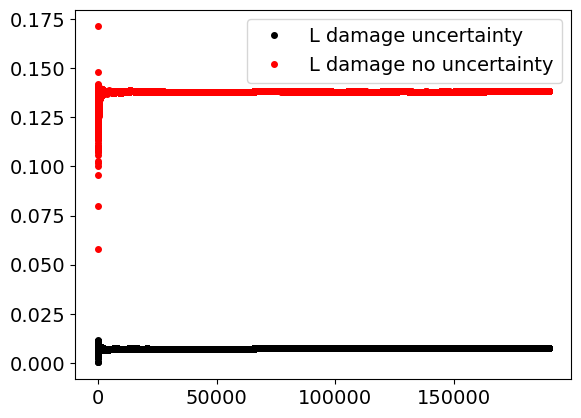

In [238]:
# lifetime damage
Ldamage_QMC = 1/(np.arange(N_samples)*k)*np.cumsum((Xin[:,1].T*Mx_func(np.array([(Xin[:,2].T*U_QMC),SigmaU_QMC,alpha_QMC]).T).ravel())**m)

# no uncertanty
Ldamage_QMC_noUncertanty = 1/(np.arange(N_samples)*k)*np.cumsum((Mx_func(np.array([U_QMC,SigmaU_QMC,alpha_QMC]).T).ravel())**m)

#plot
plt.plot(Ldamage_QMC,'o',markersize = 4,color = 'k', label = 'L damage uncertainty')
plt.plot(Ldamage_QMC_noUncertanty,'o',markersize = 4,color = 'r', label = 'L damage no uncertainty')
plt.legend()


# Limit state function and probability of failure

In [239]:

#limit state function
g =lambda x: x[:,0] - 1/(N_samples*k)*np.sum((x[:,1].T*Mx_func(np.array([(x[:,2].T*U_QMC),SigmaU_QMC,alpha_QMC]).T).ravel())**m)

gQMC = g(Xin)
print("Probability of failure: " + str(sum(gQMC<=0)/N_samples))
gQMC

Probability of failure: 0.0


c:\Users\aletc\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([1.18658909, 0.94899551, 1.33093827, ..., 0.90490058, 0.91714896,
       0.77909451])